Entrenando una inception v3 desde imagenet weights con la partcion de kaggle de Voets

In [2]:
!pip install tensorflow-gpu==2.3
!pip install typeguard
!pip install tensorflow-addons

  Using cached tensorflow_gpu-2.3.0-cp37-cp37m-manylinux2010_x86_64.whl (320.4 MB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 2.1.0 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 2.7.0 which is incompatible.
ERROR: tensorflow 2.1.0 has requirement tensorflow-estimator<2.2.0,>=2.1.0rc0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Attempting uninstall: tens

In [1]:
import numpy as np
import tensorflow as tf
import os
import random
import sys
import argparse
import csv
from glob import glob
import pickle
import gzip
import scipy
import pandas as pd
import keras
import keras.layers as layers
from keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3
from time import time
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

print(f"Numpy version: {np.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
random.seed(432)

Using TensorFlow backend.


Numpy version: 1.18.1
Tensorflow version: 2.3.0
Keras version: 2.3.1


Using TensorFlow backend.

Numpy version: 1.18.1

Tensorflow version: 2.3.0

Keras version: 2.3.1

In [2]:
import h5py
import pandas as pd

In [3]:
import layers as layers
import models as models

/opt/conda/lib/python3.7/site-packages/typeguard/__init__.py:1016: UserWarning: no type annotations present -- not typechecking layers.CrossProduct.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/opt/conda/lib/python3.7/site-packages/typeguard/__init__.py:1016: UserWarning: no type annotations present -- not typechecking layers.DensityMatrix2Dist.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/opt/conda/lib/python3.7/site-packages/typeguard/__init__.py:1016: UserWarning: no type annotations present -- not typechecking layers.DensityMatrixRegression.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
  except RuntimeError as e:
    print(e)

In [4]:
TRAIN_DIR = '/home/stoledoc/work/data2/jama16-retina-replication-master/data_2/eyepacs/train_3'
#VAL_DIR = '/home/stoledoc/work/datanfs/stoledoc/jama16-retina-replication-master/data_2/eyepacs/train_4'
TEST_DIR =  '/home/stoledoc/work/data2/jama16-retina-replication-master/data_2/eyepacs/test_3'
MESSIDOR2_DIR = '/home/stoledoc/work/data2/jama16-retina-replication-master/data/messidor2'

In [5]:
batch_size = 8

def preprocessing(image):
    image = tf.image.random_brightness(image, 0.125)
    image = tf.image.random_saturation(image, 0.5, 1.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    return image

datagen = ImageDataGenerator(
                                samplewise_center = True,
                                horizontal_flip=True,
                                rescale=1./255,
                                preprocessing_function = preprocessing,
                                validation_split=0.2
                                )

datagen_val = ImageDataGenerator(
                                samplewise_center = True,
                                rescale=1./255,
                                )

In [6]:
train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(299, 299),  
    color_mode='rgb',
    batch_size=8,
    class_mode='sparse',
    subset='training',
    #shuffle=True
)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(299, 299),  
    color_mode='rgb',
    batch_size=8,
    class_mode='sparse',
    subset='validation',
    #shuffle=False
)

Found 45464 images belonging to 5 classes.
Found 11363 images belonging to 5 classes.


In [7]:
input_tensor = Input(shape=(299, 299,3))  # this assumes K.image_data_format() == 'channels_last'
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling='avg')
# add a global spatial average pooling layer
x = base_model.output
x = Dense(2048, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

#for layer in base_model.layers:
#    layer.trainable = False

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
def loss(y_true, y_pred):
    
    #print('llegue al loss_y_true')
    #tf.print('true =', y_true/4)
    #print('llegue al loss_y_pred')
    #tf.print('pred =', y_pred)
    
    return tf.keras.losses.mean_squared_error(y_true/4, y_pred[:,0:1]) + 0.6067946695606887 * y_pred[:, 1:2]

model.compile(loss=loss, optimizer=tf.optimizers.Adam(learning_rate=7.627543070640397e-05)) #Warming up

In [9]:
model.load_weights('/home/stoledoc/work/data2/jama16-retina-replication-master/inceptionV3_keras_2_2.h5') # estos son los pesos del warming up

In [11]:
layer_name = 'global_average_pooling2d'
intermediate_layer_model = tf.keras.Model(inputs = model.input, outputs = model.get_layer(layer_name).output)

In [14]:
for layer in intermediate_layer_model.layers:
    layer.trainable = False

In [9]:
#QMR model layers set up

fm_x = layers.QFeatureMapRFF(
                            input_dim=2048,
                            dim=128, 
                            gamma=0.0005246109836455565, 
                            random_state=17)
qm = layers.QMeasureClassifEigF(dim_x=128, dim_y=5, num_eig=8)
dmregress = layers.DensityMatrixRegression()

In [12]:
psi_x = fm_x(intermediate_layer_model.output)
rho_y = qm(psi_x)
output = dmregress(rho_y)

In [13]:
qmr_layer_model = tf.keras.Model(inputs = intermediate_layer_model.input, outputs = output)

In [14]:
qmr_layer_model.compile(loss=loss, optimizer=tf.optimizers.Adam(learning_rate=7.627543070640397e-05))

In [15]:
qmr_layer_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
filepath = "warming_up_saved-model_inception+qmr_v2-{epoch:02d}-{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only = False, mode = 'min')

In [18]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           verbose=0, 
                           mode='min',  
                           restore_best_weights=True)

In [21]:
history = qmr_layer_model.fit_generator(train_generator,
                    steps_per_epoch = 45464 // batch_size,
                    epochs = 60,
                    validation_data = val_generator,
                    validation_steps =  11363 // batch_size,
                    callbacks = [checkpoint, early_stop],
                    #shuffle=True
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experime

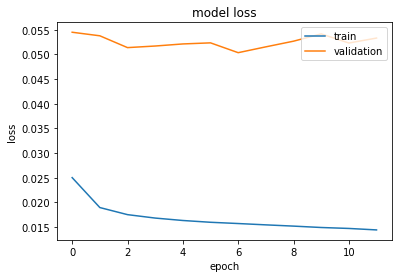

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


Listo el warming up, ahora el full training

In [12]:
#model.load_weights('/home/stoledoc/work/datanfs/stoledoc/DR+QMR/warming_up_saved-model_inception+qmr-29-0.0637.h5', by_name = True)

In [17]:
#qmr_layer_model.load_weights('/home/stoledoc/work/datanfs/stoledoc/DR+QMR/warming_up_saved-model_inception+qmr_v2-07-0.0503.h5', by_name = True)

In [21]:
qmr_layer_model.load_weights('/home/stoledoc/work/data2/Kaggle_Paper_binary/DR+QMR/full_train_saved-model_inception+qmr-14-0.0371.h5', by_name = True)

In [17]:
filepath = "full_train_saved-model_inception+qmr-{epoch:02d}-{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only = False, mode = 'min')

In [18]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           verbose=0, 
                           mode='min',  
                           restore_best_weights=True)

In [19]:
# train the model completo

history = qmr_layer_model.fit_generator(train_generator,
                    steps_per_epoch = 45463 // batch_size,
                    epochs = 100,
                    validation_data = val_generator,
                    validation_steps = 11364 // batch_size,
                    callbacks = [checkpoint, early_stop],
                    shuffle=True
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experim

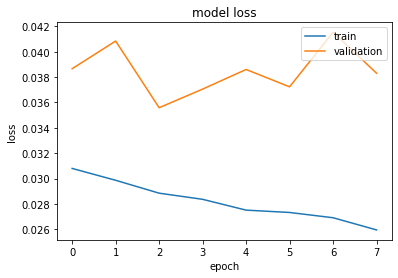

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

**Evaluando en TEST de Kaggle de esta gente**

## Keras Test

In [16]:
qmr_layer_model.load_weights('/home/stoledoc/work/data2/Kaggle_Paper_binary/DR+QMR/full_train_saved-model_inception+qmr-03-0.0356.h5', by_name = True)

In [17]:
data_dir = '/home/stoledoc/work/data2/jama16-retina-replication-master/data_2/eyepacs/test_3/' # path to the directory where the images are stored
#index =  0 # select a number here

y_preds = []
y_trues = []
stds = []

ig = ImageDataGenerator(samplewise_center = True, rescale=1./255)
gen = ig.flow_from_directory(data_dir,
                             target_size=(299, 299),  
                             color_mode='rgb',
                             class_mode='sparse',
                             batch_size = 32  # if you want batch_size > 1 you need to
                             )                        # add as many indices as your batch_size.

for i in range(8790):
    image, y_true = gen._get_batches_of_transformed_samples(np.array([i]))
    prediction = qmr_layer_model.predict(image)
    y_pred = prediction[:,0]
    std = prediction[:,1]
    y_preds.append(y_pred)
    y_trues.append(y_true)
    stds.append(std)
    
y_trues = np.asarray(y_trues)
y_trues = np.reshape(y_trues, (8790,))

y_preds = np.asarray(y_preds)
y_preds = np.reshape(y_preds, (8790,))

std = np.asarray(stds)
std = np.reshape(std, (8790,))

Found 8790 images belonging to 5 classes.


In [19]:
from sklearn.metrics import mean_absolute_error
print('------------MAE =', mean_absolute_error(y_trues, np.rint(y_preds*4)))

------------MAE = 0.28714448


In [20]:
y_trues

array([0., 0., 0., ..., 4., 4., 4.], dtype=float32)

In [21]:
np.rint(y_preds*4)

array([0., 0., 0., ..., 2., 3., 3.], dtype=float32)

In [23]:
from numpy import savetxt
savetxt('/home/stoledoc/work/data2/predictions_DQOR_Kaggle_test.csv', y_preds, delimiter = ',')

In [22]:
from sklearn.metrics import mean_absolute_error
print('------------MAE =', mean_absolute_error(y_trues, np.rint(y_preds*4)))

------------MAE = 0.28714448


## Binaryzing the results

### Looking at the actual QMR prediction using the expected value

In [26]:
binary_true = np.ones(8790)*9

for i in range(8790):
    if y_trues[i] == 0 or y_trues[i] == 1:
        binary_true[i] = 0.0
    else:
        binary_true[i] = 1.0
        
binary_true = np.reshape(binary_true, (8790,))
binary_true = np.float32(binary_true)

In [27]:
np.count_nonzero(binary_true==0)

8096

In [28]:
binary_pred = np.ones(8790)*2

threshold = (np.mean(y_preds[0:8096])+np.mean(y_preds[8096:8790]))/2
print('Threshold = ', threshold)

for i in range(8790) :
    if y_preds[i] > 0.375:#threshold:
        binary_pred[i] = 1.
    else:
        binary_pred[i] = 0.

Threshold =  0.3413407504558563


In [29]:
print(confusion_matrix(binary_true, binary_pred))

target_names = ['non-referable', 'referable']
print(classification_report(binary_true, binary_pred, target_names=target_names))

[[7941  155]
 [  93  601]]
               precision    recall  f1-score   support

non-referable       0.99      0.98      0.98      8096
    referable       0.79      0.87      0.83       694

     accuracy                           0.97      8790
    macro avg       0.89      0.92      0.91      8790
 weighted avg       0.97      0.97      0.97      8790



In [30]:
from sklearn.metrics import roc_curve, auc

In [31]:
y_prob = y_preds - y_preds.min()
y_prob = y_prob/y_prob.max()

fpr, tpr, _ = roc_curve(binary_true, y_prob)
#fpr, tpr, _ = roc_curve(y_vali, y_score)
roc_auc = auc(fpr, tpr)

print('AUC = ', roc_auc)

AUC =  0.9805758491758835


# Uncertainty 

In [32]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [33]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')

params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.0, 5.0]
   }
plt.rcParams.update(params)

In [34]:
diferencia = np.absolute((y_trues - np.rint(y_preds*4)).reshape((8790, )))

std_0 = std[np.where(diferencia == 0)]
std_1 = std[np.where(diferencia == 1)]
std_2 = std[np.where(diferencia == 2)]
std_3 = std[np.where(diferencia == 3)]
std_4 = std[np.where(diferencia == 4)]


mean_0 = np.mean(std_0, axis = 0)
std_dif_0 = np.std(std_0, axis = 0)

mean_1 = np.mean(std_1, axis = 0)
std_dif_1 = np.std(std_1, axis = 0)
mean_2 = np.mean(std_2, axis = 0)
std_dif_2 = np.std(std_2, axis = 0)
mean_3 = np.mean(std_3, axis = 0)
std_dif_3 = np.std(std_3, axis = 0)
mean_4 = np.mean(std_4, axis = 0)
std_dif_4 = np.std(std_4, axis = 0)

In [35]:
std_0 = reject_outliers(std_0, m=2)
std_1 = reject_outliers(std_1, m=2)
std_2 = reject_outliers(std_2, m=2)
std_3 = reject_outliers(std_3, m=2)
std_4 = reject_outliers(std_4, m=2)

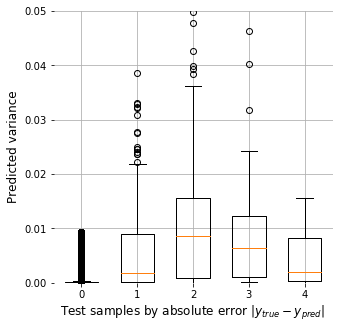

In [36]:
plt.axes(frameon=0)
plt.grid()

#plt.title('Boxplot of the variance grouped by the diference \n between predicted and true labels')#, fontdict=font)

plt.boxplot([std_0, std_1, std_2, std_3, std_4], widths = 0.6)
plt.ylim(0.00, 0.05)
plt.xticks([1,2,3,4,5], [ '0', '1','2','3','4'])
plt.ylabel('Predicted variance')
plt.xlabel('Test samples by absolute error $|y_{true} - y_{pred}|$')
plt.show()

In [37]:
diferencia = np.absolute((binary_true - binary_pred).reshape((8790, )))

In [38]:
std_0 = std[np.where(diferencia == 0)]
std_1 = std[np.where(diferencia == 1)]

mean_0 = np.mean(std_0, axis = 0)
std_dif_0 = np.std(std_0, axis = 0)

mean_1 = np.mean(std_1, axis = 0)
std_dif_1 = np.std(std_1, axis = 0)

In [39]:
std_0 = reject_outliers(std_0, m=2)
std_1 = reject_outliers(std_1, m=2)

In [40]:
plt.style.use('fivethirtyeight')

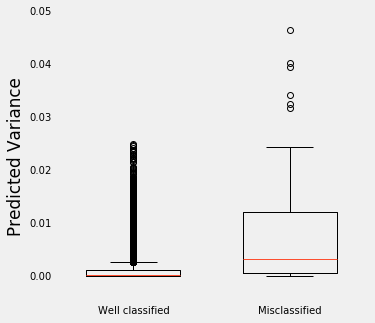

In [45]:
plt.axes(frameon=0)
plt.grid()

#plt.title('Boxplot of the variance grouped by the diference \n between predicted and true labels')#, fontdict=font)

plt.boxplot([std_0, std_1], widths = 0.6)
plt.ylim(-0.005, 0.05)
plt.xticks([1,2], [ 'Well classified', 'Misclassified'])
plt.ylabel('Predicted Variance')
#plt.xlabel('EyePacs Test samples by classification status')
plt.show()

In [43]:
diferencia = (binary_true - binary_pred).reshape((8790, ))

In [44]:
TN = std[np.where((diferencia == 0) & (binary_true ==  0))]
TP = std[np.where((diferencia == 0) & (binary_true ==  1))]
FN = std[np.where((diferencia == 1))]
FP = std[np.where((diferencia == -1))]

mean_TN = np.mean(TN, axis = 0)
std_dif_TN = np.std(TN, axis = 0)

mean_TP = np.mean(TP, axis = 0)
std_dif_TP = np.std(TP, axis = 0)

mean_FN = np.mean(FN, axis = 0)
std_dif_FN = np.std(FN, axis = 0)

mean_FP = np.mean(FP, axis = 0)
std_dif_FP = np.std(FP, axis = 0)

In [45]:
TN = reject_outliers(TN, m=2)
TP = reject_outliers(TP, m=2)
FN = reject_outliers(FN, m=2)
FP = reject_outliers(FP, m=2)

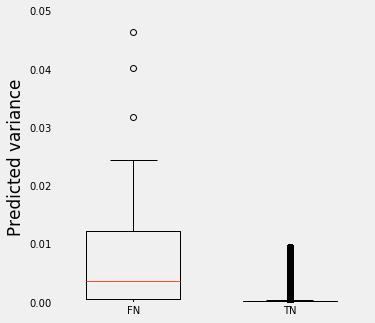

In [46]:
plt.axes(frameon=0)
plt.grid()

#plt.title('Boxplot of the variance grouped by the diference \n between predicted and true labels')#, fontdict=font)

plt.boxplot([FN, TN], widths = 0.6)
plt.ylim(0.00, 0.05)
plt.xticks([1,2], [ 'FN', 'TN'])
plt.ylabel('Predicted variance')
#plt.xlabel('Test samples by absolute error $|y_{true} - y_{pred}|$')
plt.show()

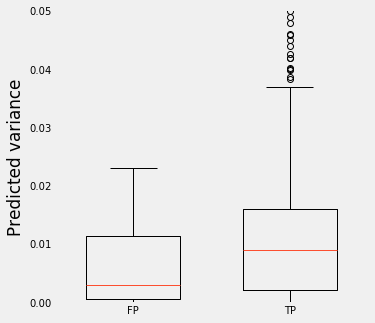

In [47]:
plt.axes(frameon=0)
plt.grid()

#plt.title('Boxplot of the variance grouped by the diference \n between predicted and true labels')#, fontdict=font)

plt.boxplot([FP, TP], widths = 0.6)
plt.ylim(0.00, 0.05)
plt.xticks([1,2], [ 'FP', 'TP'])
plt.ylabel('Predicted variance')
#plt.xlabel('Test samples by absolute error $|y_{true} - y_{pred}|$')
plt.show()

# Extracting features

In [18]:
qmr_layer_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
layer_name = 'q_feature_map_rff'
#layer_name = 'dense'
intermediate_layer_model = tf.keras.Model(inputs=qmr_layer_model.input, outputs=qmr_layer_model.get_layer(layer_name).output)

In [20]:
intermediate_layer_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [22]:
data_dir = '/home/stoledoc/work/datanfs/stoledoc/jama16-retina-replication-master/data_2/messidor2/' # path to the directory where the images are stored
#index =  0 # select a number here
names = []
features = []
labels = []

ig = ImageDataGenerator(samplewise_center = True, rescale=1./255)
gen = ig.flow_from_directory(data_dir,
                             target_size=(299, 299),  
                             color_mode='rgb',
                             class_mode='binary',
                             batch_size = 32  # if you want batch_size > 1 you need to
                             )                        # add as many indices as your batch_size.

for i in range(1744):
    image, label = gen._get_batches_of_transformed_samples(np.array([i]))
    image_name = gen.filenames[i][2:]
    names.append(image_name)
    # do whatever you want with your image and label
    feature = intermediate_layer_model.predict(image)
    features.append(feature)
    labels.append(label)
    
labels = np.asarray(labels)
labels = np.reshape(labels, (1744,))

features = np.asarray(features)
features = np.reshape(features, [1744,128])

messidor = pd.DataFrame(names)
messidor.to_csv('messidor_2_grading_05-05-21.csv', index=False, header = False)

with h5py.File("inceptionv3_qmr_128_features_messidor_2_grading_05-05-21.hdf5", "w") as datafile:

    datafile.create_dataset("features",(1744,128),dtype=np.float32)
    datafile.create_dataset("Retinopathy",(1744,),dtype=np.uint8)

    datafile["features"][:]=features
    datafile["Retinopathy"][:]=labels

Found 1744 images belonging to 5 classes.


In [23]:
data_dir = '/home/stoledoc/work/datanfs/stoledoc/jama16-retina-replication-master/data_2/eyepacs/test_3' # path to the directory where the images are stored
#index =  0 # select a number here
names = []
features = []
labels = []

ig = ImageDataGenerator(samplewise_center = True, rescale=1./255)
gen = ig.flow_from_directory(data_dir,
                             target_size=(299, 299),  
                             color_mode='rgb',
                             class_mode='binary',
                             batch_size = 32  # if you want batch_size > 1 you need to
                             )                        # add as many indices as your batch_size.

for i in range(8790):
    image, label = gen._get_batches_of_transformed_samples(np.array([i]))
    image_name = gen.filenames[i][2:]
    names.append(image_name)
    # do whatever you want with your image and label
    feature = intermediate_layer_model.predict(image)
    features.append(feature)
    labels.append(label)
    
labels = np.asarray(labels)
labels = np.reshape(labels, (8790,))

features = np.asarray(features)
features = np.reshape(features, [8790,128])

messidor = pd.DataFrame(names)
messidor.to_csv('inceptionv3_qmr_128_features_test_kaggle_05-05-21.csv', index=False, header = False)

with h5py.File("inceptionv3_qmr_128_features_test_kaggle_05-05-21.hdf5", "w") as datafile:

    datafile.create_dataset("features",(8790,128),dtype=np.float32)
    datafile.create_dataset("Retinopathy",(8790,),dtype=np.uint8)

    datafile["features"][:]=features
    datafile["Retinopathy"][:]=labels

Found 8790 images belonging to 5 classes.


# Let's paint

In [34]:
from sklearn.decomposition import PCA, KernelPCA

In [24]:
with h5py.File("inceptionv3_qmr_128_features_test_kaggle_05-05-21.hdf5", "r") as datafile:
    features_kaggle_test = datafile["features"][:]
    grades_kaggle_test = datafile["Retinopathy"][:]

In [27]:
features_kaggle_test.shape

(8790, 128)

In [31]:
print(np.count_nonzero(grades_kaggle_test==0))
print(np.count_nonzero(grades_kaggle_test==1))
print(np.count_nonzero(grades_kaggle_test==2))
print(np.count_nonzero(grades_kaggle_test==3))
print(np.count_nonzero(grades_kaggle_test==4))

7407
689
0
0
694


In [32]:
X = features_kaggle_test

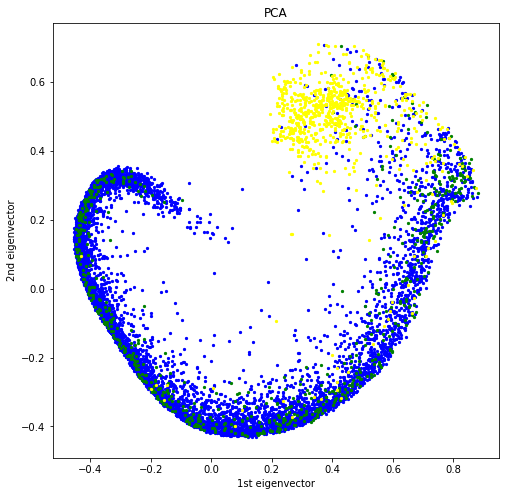

In [36]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 8))

X_reduced = PCA(n_components=2).fit_transform(X)
#KPCA = KernelPCA(n_components=2, kernel = 'rbf', gamma = 0.1317, fit_inverse_transform=True)

#KPCA = KernelPCA(n_components=2, kernel = 'rbf' , gamma = 0.005, fit_inverse_transform=True)

#KPCA.fit(X)

#X_reduced = KPCA.transform(X)

#plt.contourf(x,y,z)
plt.scatter(X_reduced[0:7407, 0], X_reduced[0:7407, 1], c='blue',  edgecolor=None, s=5)
plt.scatter(X_reduced[7407:8093, 0], X_reduced[7407:8093, 1], c='green',  edgecolor=None, s=5)
#plt.scatter(X_reduced[9358:15523, 0], X_reduced[9358:15523, 1], c='red',  edgecolor=None, s=5)
#plt.scatter(X_reduced[15523:16456, 0], X_reduced[15523:16456, 1], c='black',  edgecolor=None, s=5)
plt.scatter(X_reduced[8093:8790, 0], X_reduced[8093:8790, 1], c='yellow',  edgecolor=None, s=5)
plt.title("PCA")
plt.xlabel("1st eigenvector")

plt.ylabel("2nd eigenvector")
#plt.colorbar()


plt.show()

# Pedicting with Inception

In [10]:
data_dir = '/home/stoledoc/work/data2/jama16-retina-replication-master/data_2/eyepacs/test_3/' # path to the directory where the images are stored
#index =  0 # select a number here

y_preds = []
y_trues = []
stds = []

ig = ImageDataGenerator(samplewise_center = True, rescale=1./255)
gen = ig.flow_from_directory(data_dir,
                             target_size=(299, 299),  
                             color_mode='rgb',
                             class_mode='sparse',
                             batch_size = 32  # if you want batch_size > 1 you need to
                             )                        # add as many indices as your batch_size.

for i in range(8790):
    image, y_true = gen._get_batches_of_transformed_samples(np.array([i]))
    prediction = model.predict(image)
    y_pred = prediction[:,0]
    #std = prediction[:,1]
    y_preds.append(y_pred)
    y_trues.append(y_true)
    #stds.append(std)
    
y_trues = np.asarray(y_trues)
y_trues = np.reshape(y_trues, (8790,))

y_preds = np.asarray(y_preds)
y_preds = np.reshape(y_preds, (8790,))

#std = np.asarray(stds)
#std = np.reshape(std, (8790,))

Found 8790 images belonging to 5 classes.


In [12]:
from numpy import savetxt
savetxt('/home/stoledoc/work/data2/predictions_inception_Kaggle_test.csv', y_preds, delimiter = ',')

## Messidor

In [14]:
data_dir = '/home/stoledoc/work/data2/jama16-retina-replication-master/data/messidor2' # path to the directory where the images are stored
#index =  0 # select a number here

y_preds = []
y_trues = []
std = []

ig = ImageDataGenerator(samplewise_center = True, rescale=1./255)
gen = ig.flow_from_directory(data_dir,
                             target_size=(299, 299),  
                             color_mode='rgb',
                             class_mode='sparse',
                             batch_size = 32  # if you want batch_size > 1 you need to
                             )                        # add as many indices as your batch_size.

for i in range(1748):
    image, y_true = gen._get_batches_of_transformed_samples(np.array([i]))
    y_pred = model.predict(image)[:,0]
    y_preds.append(y_pred)
    y_trues.append(y_true)
    
y_trues = np.asarray(y_trues)
y_trues = np.reshape(y_trues, (1748,))

y_preds = np.asarray(y_preds)
y_preds = np.reshape(y_preds, (1748,))


Found 1748 images belonging to 2 classes.


In [16]:
from numpy import savetxt
savetxt('/home/stoledoc/work/data2/predictions_inception_messidor2.csv', y_preds, delimiter = ',')